# Rename raw files

In [1]:
import os
import re
import shutil
import glob
import numpy as np
import nd2
import matplotlib.pyplot as plt
import tifffile
import numpy as np
import cv2
from tqdm.notebook import tqdm

from ioMicro import *

In [2]:
wd = r'U:\Scientific Data\RG-AS04-Data01\Yinan\23-08-29'

In [3]:
raw_files_dir= wd + os.sep + 'raw_incoming'

In [ ]:
raw_files_n = raw_files_dir +os.sep+ '*\*.nd2'
raw_fls = glob.glob(raw_files_n)
fls = sorted(raw_fls, key=lambda t: os.stat(t).st_mtime)
fls_list = np.reshape(fls, (17, 43))
fls_list[1, 3]

In [ ]:
offset = 46
points = ['' for _ in range(fls_list.shape[1])]
import re
for ihyb in range(fls_list.shape[0]):
    for ifov in range(fls_list.shape[1]):
        src_fl = fls_list[ihyb, ifov]
        points[ifov] = re.search(r'Point([^_]+)_', src_fl).group(1)
        if not os.path.exists(src_fl): continue
        dst_fl = raw_files_dir + os.sep + 'hyb' + str(ihyb+offset+1).zfill(3) + '_Point' + points[ifov] + '.nd2'
        #print(src_fl + '->' + dst_fl)
        os.rename(src_fl, dst_fl)

Only done for the first tube change

In [11]:
np.savez(wd+os.sep+'points.npz', points=points)

# Export DAPI channel as new .tif file

In [3]:
raw_files_dir = wd + os.sep + 'rawdata'
points = np.load(wd+os.sep+'points.npz')['points']

In [4]:
dapi_dir = raw_files_dir + os.sep + 'dapi_tifs'
ch_dapi = 0

nhybs = len(glob.glob(raw_files_dir + os.sep + '*_Point' + points[0] + '.nd2'))
if not os.path.exists(dapi_dir):
    os.mkdir(dapi_dir)

In [11]:
for ihyb in tqdm(range(offset, nhybs)):
    for ifov in range(len(points)):
        file = raw_files_dir + os.sep + 'hyb' + str(ihyb+1).zfill(3) + '_Point' + points[ifov] + '.nd2'
        fl_out = 'hyb'+ str(ihyb+1).zfill(3) + '_Point' + points[ifov] + '_DAPI'
        if os.path.exists(dapi_dir + os.sep + fl_out+ '.tif') and os.path.exists(dapi_dir + os.sep + fl_out+ '_xzProjection.tif') and os.path.exists(dapi_dir + os.sep + fl_out+ '_xyProjection.tif'): continue
        im_dapi = nd2.imread(file)[:, ch_dapi]
        #print("Saving " + file + '->' + fl_out)
        tifffile.imsave(dapi_dir + os.sep + fl_out + '.tif', im_dapi)
        tifffile.imsave(dapi_dir + os.sep + fl_out + '_xyProjection.tif', np.max(im_dapi, axis=0))
        tifffile.imsave(dapi_dir + os.sep + fl_out + '_xzProjection.tif', np.max(im_dapi, axis=1))
        tifffile.imsave(dapi_dir + os.sep + fl_out + '_yzProjection.tif', np.max(im_dapi, axis=2))

100%|██████████████████████████████████████████████████████████████████████████████| 17/17 [6:44:55<00:00, 1429.14s/it]


# Register tiles using DAPI channel

In [3]:
wd = r'U:\Scientific Data\RG-AS04-Data01\Yinan\23-08-29'
raw_files_dir = wd + os.sep + 'rawdata'
dapi_dir = raw_files_dir + os.sep + 'dapi_tifs'

In [4]:
# 75p data
points_all = [l+n for l in 'ABCDEFGH' for n in '1234']
X,Y = np.mgrid[0:8, 0:4]

points_75p = ['H1', 'H2', \
              'G1', 'G2', 'G3', \
              'F1', 'F2', 'F3', 'F4', \
              'E1', 'E2', 'E3', 'E4', \
              'D1', 'D2', 'D3', 'D4', \
              'C1', 'C2', 'C3', 'C4', \
                    'B2', 'B3', 'B4', \
                    'A2', 'A3', 'A4']
fls = [dapi_dir + os.sep + 'hyb063_Point'+ p +'_DAPI.tif' for p in points_75p]
points_id = [points_all.index(p) for p in points_75p]


tileidx = np.transpose(np.vstack([X.ravel(), Y.ravel()]))[points_id]
tileidx.shape

(27, 2)

In [5]:
pairs,offsets = tile_registration(fls, 0, tileidx, overlap=10)

Registering between (7, 0) and (7, 1)
[    1    12 -2078]
Registering between (6, 0) and (7, 0)
[   -1 -2078   -11]
Registering between (6, 0) and (6, 1)
[    1    15 -2081]
Registering between (6, 1) and (7, 1)
[   -1 -2080   -10]
Registering between (6, 1) and (6, 2)
[    2    11 -2073]
Registering between (5, 0) and (6, 0)
[   -1 -2082   -14]
Registering between (5, 0) and (5, 1)
[    2    13 -2079]
Registering between (5, 1) and (6, 1)
[   -1 -2078   -15]
Registering between (5, 1) and (5, 2)
[    0    13 -2079]
Registering between (5, 2) and (6, 2)
[    1 -2081   -10]
Registering between (5, 2) and (5, 3)
[    2     8 -2078]
Registering between (4, 0) and (5, 0)
[   -1 -2078   -12]
Registering between (4, 0) and (4, 1)
[    1    11 -2078]
Registering between (4, 1) and (5, 1)
[   -1 -2075   -14]
Registering between (4, 1) and (4, 2)
[    1    15 -2080]
Registering between (4, 2) and (5, 2)
[   -2 -2078   -11]
Registering between (4, 2) and (4, 3)
[    1    14 -2077]
Registering be

In [6]:
offsets_abs = np.zeros([27, 3], dtype=int)
for i in range(len(pairs)): 
    if pairs[i][1] > pairs[i][0]:
        offsets_abs[pairs[i][1]] = offsets_abs[pairs[i][0]] - offsets[i]
    else:
        offsets_abs[pairs[i][0]] = offsets_abs[pairs[i][1]] + offsets[i]
    
print(offsets_abs)
save_tile_fl = wd + os.sep + 'Result'+ os.sep + 'tiles_reg_75p.npz'
np.savez(save_tile_fl,pairs = pairs, offsets = offsets, tileidx = tileidx, offsets_abs = offsets_abs, points=points_75p)

[[     0      0      0]
 [    -1    -12   2078]
 [    -1  -2078    -11]
 [    -2  -2092   2068]
 [    -4  -2103   4141]
 [    -2  -4160    -25]
 [    -3  -4170   2053]
 [    -3  -4184   4131]
 [    -5  -4192   6209]
 [    -3  -6238    -37]
 [    -4  -6245   2039]
 [    -5  -6262   4120]
 [    -6  -6276   6197]
 [    -3  -8316    -49]
 [    -4  -8324   2027]
 [    -5  -8341   4104]
 [    -6  -8353   6182]
 [    -5 -10395    -63]
 [    -6 -10406   2015]
 [    -7 -10418   4095]
 [    -7 -10432   6172]
 [    -6 -12485   1998]
 [    -7 -12497   4079]
 [    -9 -12507   6159]
 [    -3 -14565   1991]
 [   -10 -14572   4068]
 [   -11 -14591   6145]]


In [7]:
# 50p data
X,Y = np.mgrid[0:4, 0:4]

points_50p = ['0027', '0028', '0029', '0030',\
              '0034', '0033', '0032', '0031',\
              '0035', '0036', '0037', '0038',\
              '0042', '0041', '0040', '0039']

fls = [dapi_dir + os.sep + 'hyb063_Point'+ p +'_DAPI.tif' for p in points_50p]

tileidx = np.transpose(np.vstack([X.ravel(), Y.ravel()]))

In [8]:
pairs,offsets = tile_registration(fls, 0, tileidx, overlap=20)
offsets_abs = np.zeros([16, 3], dtype=int)
for i in range(len(pairs)): 
    if pairs[i][1] > pairs[i][0]:
        offsets_abs[pairs[i][1]] = offsets_abs[pairs[i][0]] - offsets[i]
    else:
        offsets_abs[pairs[i][0]] = offsets_abs[pairs[i][1]] + offsets[i]
    
print(offsets_abs)
save_tile_fl = wd + os.sep + 'Result'+ os.sep + 'tiles_reg_50p.npz'
np.savez(save_tile_fl,pairs = pairs, offsets = offsets, tileidx = tileidx, offsets_abs = offsets_abs, points=points_50p)

Registering between (0, 0) and (0, 1)
[    0     8 -2078]
Registering between (0, 0) and (1, 0)
[    1 -2079    -8]
Registering between (0, 1) and (0, 2)
[   -1    14 -2077]
Registering between (0, 1) and (1, 1)
[    2 -2069    -8]
Registering between (0, 2) and (0, 3)
[   -1    16 -2079]
Registering between (0, 2) and (1, 2)
[    1 -2077    -6]
Registering between (0, 3) and (1, 3)
[    0 -2080   -11]
Registering between (1, 0) and (1, 1)
[    0    15 -2077]
Registering between (1, 0) and (2, 0)
[    1 -2078   -14]
Registering between (1, 1) and (1, 2)
[   -2     8 -2074]
Registering between (1, 1) and (2, 1)
[    0 -2081   -16]
Registering between (1, 2) and (1, 3)
[   -2    13 -2083]
Registering between (1, 2) and (2, 2)
[    0 -2076   -21]
Registering between (1, 3) and (2, 3)
[   -8 -1843     0]
Registering between (2, 0) and (2, 1)
[   -1    12 -2080]
Registering between (2, 0) and (3, 0)
[    0 -2081   -10]
Registering between (2, 1) and (2, 2)
[   -2    13 -2078]
Registering be

# Estimate the drift between rounds

In [6]:
import os
import glob
import numpy as np
import tifffile
import skimage.io

In [7]:
wd = r'U:\Scientific Data\RG-AS04-Data01\Yinan\23-08-29'
raw_files_dir= wd + os.sep + 'rawdata'
data_folder = raw_files_dir +os.sep +'dapi_tifs'
points = np.load(wd + os.sep + 'points.npz')['points']

In [8]:
drift_folder = r'U:\Scientific Data\RG-AS04-Data01\Yinan\23-08-29\drift_correction'

### calculate features from the DAPI channel

In [8]:
fls = np.sort(glob.glob(data_folder + os.sep + '*_DAPI.tif'))
for f in fls:
    basename = os.path.basename(f).split('_DAPI')[0]
    if os.path.exists(drift_folder + os.sep + basename + '_DapiFeats.npz'):
        continue
    print(basename)
    im = tifffile.imread(f)
    obj = get_dapi_features(im, drift_folder + os.sep + basename + '_DapiFeats.npz', psf_fl = 'psf_cy5.npy')

### drift estimation based on DAPI features

In [ ]:
# Use hyb middle as reference
ref_hyb = 23 #hyb 24
for fov in range(len(points)):   
    fls = np.sort(glob.glob(drift_folder + os.sep + '*' + points[fov] +'*_DapiFeats.npz'))
    rtxyz = []
    obj0 = get_dapi_features(None, fls[ref_hyb])
    for t in range(len(fls)):
        obj1 = get_dapi_features(None, fls[t])
        #txyz,txyzs = get_txyz(im_dapi0,im_dapi1,sz_norm=20,sz = 150,nelems=25,plt_val=False)
        tzxyf, cptzxy_plus, cptzxy_minus, Nplus, Nminus = get_txyz_dapi_features(obj0, obj1)
        rtxyz.append(tzxyf)
        print('Point' + points[fov] +', R' + str(t+1) + '-R' + str(ref_hyb+1) + ': ' + str(cptzxy_plus) + str(Nplus) + str(cptzxy_minus) + str(Nminus) + str(tzxyf))
    np.savez(drift_folder + os.sep + 'drift_correction_Point' + points[fov] + '.npz', rtxyz=rtxyz,fls=fls)

C:\Users\wan0000\AppData\Local\Temp\ipykernel_20668\1874526994.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(12, 4, fov+1)


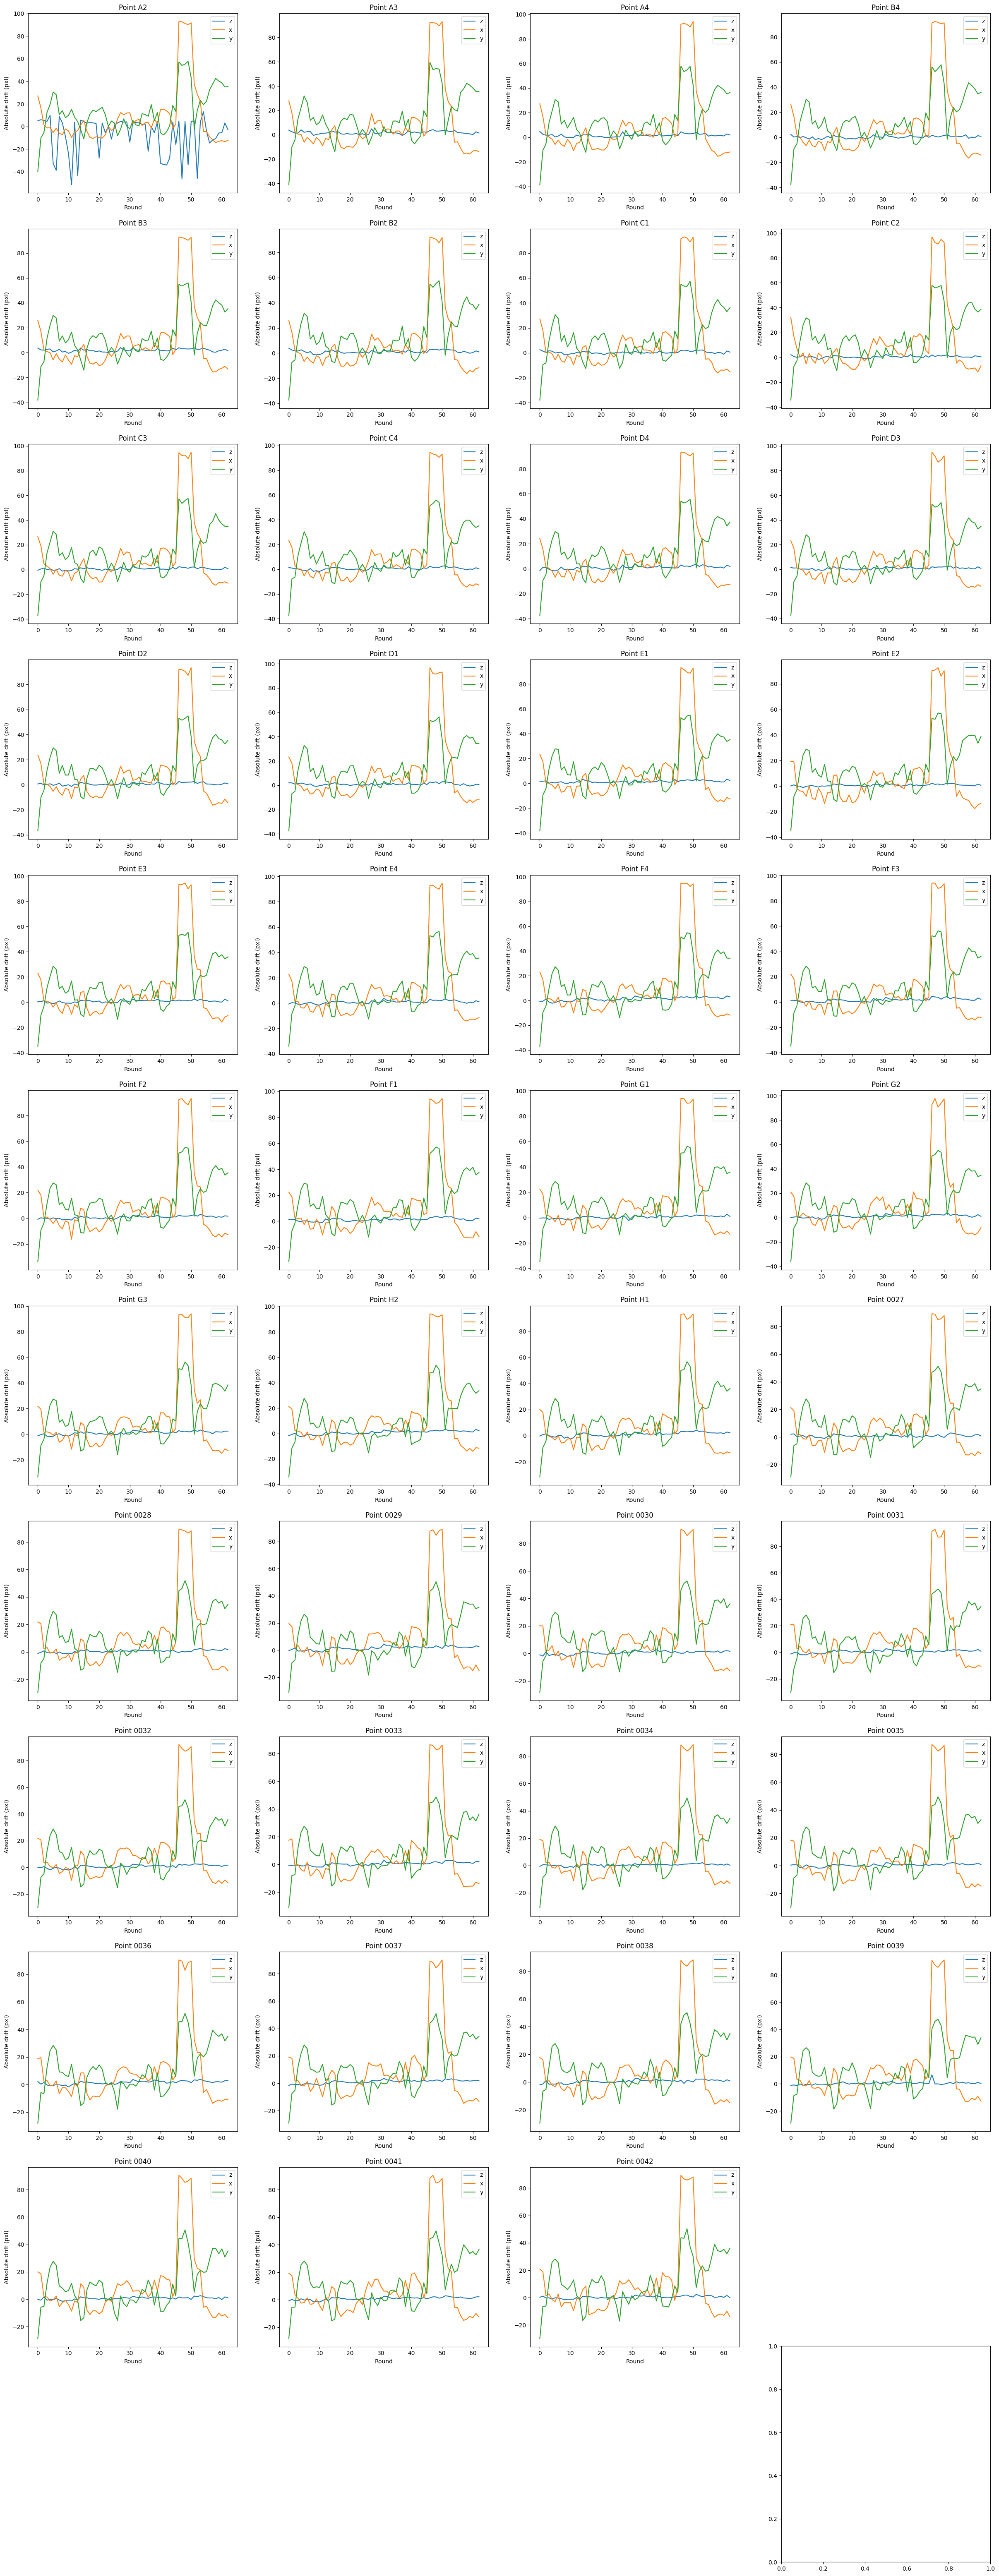

In [13]:
#plot the drift across rounds for all fields of view
plt.subplots(10, 4, figsize=(30,80))
for fov in range(len(points)):
    rtxyz = np.load(drift_folder + os.sep + 'drift_correction_Point' + points[fov] + '.npz',allow_pickle=True)['rtxyz']
    plt.subplot(12, 4, fov+1)
    plt.plot(np.asarray(rtxyz))
    plt.legend(['z', 'x', 'y'])
    plt.xlabel('Round')
    plt.ylabel('Absolute drift (pxl)')
    plt.title('Point ' + points[fov])
plt.show()   

# Dot detection

In [15]:
import glob
import os
import nd2
import matplotlib.pyplot
import tifffile
import numpy as np
import re
import shutil
import cv2
from tqdm.notebook import tqdm
import napari

In [16]:
wd = r'U:\Scientific Data\RG-AS04-Data01\Yinan\23-08-29'
raw_files_dir= wd + os.sep + 'rawdata'
result_dir = wd + os.sep + 'Result'
spot_dir = result_dir +  os.sep + 'called_spots'
if not os.path.exists(spot_dir):
    os.mkdir(spot_dir)
point_list = np.load(wd + os.sep + 'points.npz')['points']

In [18]:
dic_bM = dict()
dic_bM[1] = np.load('cy3_bM.npz')['bM']
dic_bM[2] = np.load('cy5_bM.npz')['bM']

In [ ]:
th_fit = 80
delta=2
delta_fit=4
sigmaZ=2.5
sigmaXY=1.85
for ip in range(len(point_list)): # for each Field of View
    print('processing fov ' + point_list[ip])
    fls = np.sort(glob.glob(raw_files_dir + os.sep + '*' + point_list[ip] +'*.nd2'))
    for t in range(len(fls)): #for each hyb
        if os.path.exists(spot_dir + os.sep + 'hyb' +str(t+1).zfill(3) + '_Point' + point_list[ip] + '_ch2_th' + str(th_fit)+'.npz'):
            continue
        img = nd2.imread(fls[t])
        for sig_ch in range(1,3):
            im = img[:, sig_ch]
            im_ = np.array(im,dtype=np.float32)
            
            im_ = np.array([(im__-dic_bM[sig_ch][1])/dic_bM[sig_ch][0] for im__ in im_])
            #im_sig_ = norm_slice_ref(im1_sig,ref_ims[sig_ch], s=100)
            
            imD = full_deconv(im_,s_=500,pad=100,psf=np.load('psf_cy5.npy'),
                        parameters={'method': 'wiener', 'beta': 0.001, 'niter': 50},gpu=True,force=False)
            imDn = norm_slice(imD,s=100)
            
            
            #Xh = get_local_max_gaussian(im_sig_,th_fit,delta=delta,delta_fit=delta_fit,dbscan=True,sigmaZ=sigmaZ, sigmaXY=sigmaXY,
            #                return_centers=False,mins=None)
            Xh = get_local_maxfast_tensor(imDn,th_fit=th_fit,im_raw=im_,dic_psf=None,delta=delta,delta_fit=delta_fit,sigmaZ=sigmaZ,sigmaXY=sigmaXY)
            save_fit_fl = spot_dir + os.sep + 'hyb' +str(t+1).zfill(3) + '_Point' + point_list[ip] + '_ch' + str(sig_ch) + '_th' + str(th_fit)+'.npz'
            np.savez_compressed(save_fit_fl,Xh)

# Cell segmentation

In [3]:
import glob
import os
import numpy as np
resc = 4
rescz = 1

In [4]:
wd = r'U:\Scientific Data\RG-AS04-Data01\Yinan\23-08-29'
raw_files_dir = wd + os.sep + 'rawdata'
points = np.load(wd + os.sep + 'points.npz')['points']
fls = [raw_files_dir + os.sep + 'hyb063_Point' + p + '.nd2' for p in points]

In [8]:
for ip in range(len(points)):
    save_seg_fl = wd + os.sep + 'Result' + os.sep + 'hyb063_Point' + points[ip] +'_seg.npz'
    print('Segmenting ' + points[ip])
    if os.path.exists(save_seg_fl):
        continue
    masks, masks_mem, masks_nuc, dict_type = cell_segmentation(fls[ip], save_seg_fl, ch_nuc=0, ch_mem=2, resc=resc, rescz=rescz, cellprob_mem=-5, cellprobe_nuc=-5, cellprobe_thres=0, anisotropy=0.69)

Segmenting A2


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 16.98it/s]
C:\Users\wan0000\AppData\Local\Temp\ipykernel_14992\4089131426.py:6: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  masks, masks_mem, masks_nuc, dict_type = cell_segmentation(fls[ip], save_seg_fl, ch_nuc=0, ch_mem=2, resc=resc, rescz=rescz, cellprob_mem=-5, cellprobe_nuc=-5, cellprobe_thres=0, anisotropy=0.69)


Segmenting A3


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.44it/s]


Segmenting A4


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.76it/s]


Segmenting B4


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.68it/s]


Segmenting B3


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.52it/s]


Segmenting B2


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:12<00:00, 18.08it/s]


Segmenting C1


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.77it/s]


Segmenting C2


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 16.93it/s]


Segmenting C3


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 18.01it/s]


Segmenting C4


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.81it/s]


Segmenting D4


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.77it/s]


Segmenting D3


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.95it/s]


Segmenting D2


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.11it/s]


Segmenting D1


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.76it/s]


Segmenting E1


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.74it/s]


Segmenting E2


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 18.04it/s]


Segmenting E3


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:14<00:00, 16.72it/s]


Segmenting E4


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.89it/s]


Segmenting F4


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:12<00:00, 18.20it/s]


Segmenting F3


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.27it/s]


Segmenting F2


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.56it/s]


Segmenting F1


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.86it/s]


Segmenting G1


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.13it/s]


Segmenting G2


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:15<00:00, 15.63it/s]


Segmenting G3


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.33it/s]


Segmenting H2


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.70it/s]


Segmenting H1


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.71it/s]


Segmenting 0027


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.91it/s]


Segmenting 0028


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:16<00:00, 14.14it/s]


Segmenting 0029


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:14<00:00, 16.08it/s]


Segmenting 0030


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.75it/s]


Segmenting 0031


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.36it/s]


Segmenting 0032


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.67it/s]


Segmenting 0033


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.59it/s]


Segmenting 0034


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.43it/s]


Segmenting 0035


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:14<00:00, 16.62it/s]


Segmenting 0036


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.36it/s]


Segmenting 0037


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.04it/s]


Segmenting 0038


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.35it/s]


Segmenting 0039


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.66it/s]


Segmenting 0040


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.82it/s]


Segmenting 0041


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:14<00:00, 16.70it/s]


Segmenting 0042


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:12<00:00, 18.23it/s]


## Segment EVL

In [3]:
wd =  r'U:\Scientific Data\RG-AS04-Data01\Yinan\23-08-29'
nhyb_mem = 63
ch_dapi = 0  
ch_mem = 2 
nhyb_evl = 56 #krt4 gene
ch_evl = 2

In [ ]:
points = np.load(wd + os.sep + 'points.npz')['points']
for p in points:
    print('Processing fov ' + p)
    mask = segment_EVL(wd, p, nhyb_mem, ch_dapi, ch_mem, nhyb_evl, ch_evl)

Processing fov A2


In [ ]:
points = np.load(wd + os.sep + 'points.npz')['points']
for p in points:
    print('Processing fov ' + p)
    mask = incorporate_evl(wd, p, nhyb_mem)

In [4]:
result_dir = wd + os.sep + 'Result'
fl_tile_reg = result_dir + os.sep + 'tiles_reg_75p.npz'
points = np.load(fl_tile_reg)['points']

In [ ]:
fls_seg = [result_dir + os.sep+ 'hyb063_Point'+p+'_evl_seg.npz' for p in points]
consolidate_seg_masks(fls_seg, fl_tile_reg, points)
fl_dict = wd + os.sep + 'Result' + os.sep + 'cell_dict_75p.npz'
extract_cellinfo(fls_seg, fl_tile_reg, fl_dict)

In [5]:
cellcms = np.load(fl_dict, allow_pickle=True)['cellcms'].item()
cellvols = np.load(fl_dict, allow_pickle=True)['cellvols'].item()
cellFOVs = np.load(fl_dict, allow_pickle=True)['cellFOVs'].item()
len(cellcms)

19283

(-14933.640980010883,
 1839.5749145273724,
 -428.7121386136875,
 8868.491163579469)

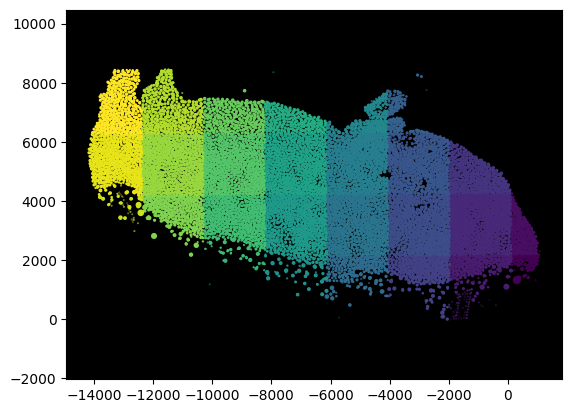

In [6]:
import matplotlib.pyplot as plt
plt.figure()
plt.rcParams['axes.facecolor']='black'
cms = np.array(list(cellcms.values()))
vols = np.array(list(cellvols.values()))
FOVs = np.array(list(cellFOVs.values()))
plt.scatter(cms[:,1],cms[:,2], s=vols/np.median(vols), c=FOVs)
plt.axis('equal')

In [ ]:
fls_mask = [result_dir + os.sep+ 'hyb063_Point' + p + '_evl_seg_corr_newID.npz' for p in points]
unif_mask = calculate_unified_mask(fl_tile_reg, fls_mask, resc=4)
import tifffile
tifffile.imwrite(result_dir + os.sep + '75p_unif_mask_ds4.tif', unif_mask)

In [ ]:
fl_tile_reg = result_dir + os.sep + 'tiles_reg_50p.npz'
points = np.load(fl_tile_reg)['points']
fl_dict = wd + os.sep + 'Result' + os.sep + 'cell_dict_50p.npz'
fls_seg = [result_dir + os.sep+ 'hyb063_Point'+p+'_evl_seg.npz' for p in points]
consolidate_seg_masks(fls_seg, fl_tile_reg, points)
fl_dict = wd + os.sep + 'Result' + os.sep + 'cell_dict_50p.npz'
extract_cellinfo(fls_seg, fl_tile_reg, fl_dict)

In [7]:
fl_dict = wd + os.sep + 'Result' + os.sep + 'cell_dict_50p.npz'
cellcms = np.load(fl_dict, allow_pickle=True)['cellcms'].item()
cellvols = np.load(fl_dict, allow_pickle=True)['cellvols'].item()
cellFOVs = np.load(fl_dict, allow_pickle=True)['cellFOVs'].item()
len(cellcms)

8816

(-410.29760715247664, 8912.420936344155, -281.6726442117866, 8919.107397345706)

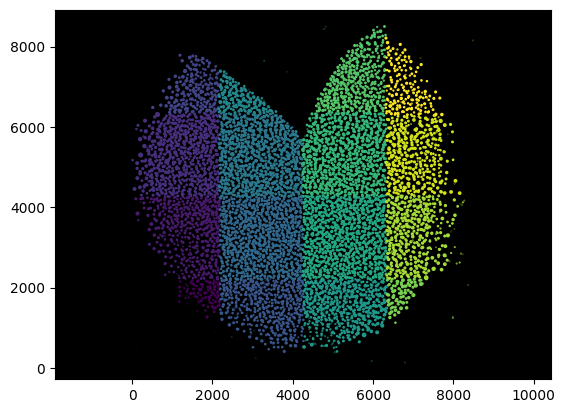

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.rcParams['axes.facecolor']='black'
cms = np.array(list(cellcms.values()))
vols = np.array(list(cellvols.values()))
FOVs = np.array(list(cellFOVs.values()))
plt.scatter(cms[:,1],cms[:,2], s=vols/np.median(vols), c=FOVs)
plt.axis('equal')

In [ ]:
fls_mask = [result_dir + os.sep+ 'hyb063_Point' + p + '_evl_seg_corr_newID.npz' for p in points]
unif_mask = calculate_unified_mask(fl_tile_reg, fls_mask, resc=4)
import tifffile
tifffile.imwrite(result_dir + os.sep + '50p_unif_mask_ds4.tif', unif_mask)

## Spot-based decoding

In [10]:
import torch
import sys
import os

In [11]:
analysis_folder =r'U:\Scientific Data\RG-AS04-Data01\Yinan\23-08-29'
points = np.load(analysis_folder + os.sep + 'points.npz')['points']
lib_file = analysis_folder + os.sep + 'codebook40-4-4_TOME_minHdist4_any3.csv'


nhybs = 63
blank_code_n = 0
distance_th_bg = 6
distance_th_sm = 2.5

dec = decoder(analysis_folder = analysis_folder,force=True)
dec.load_library_v2(lib_fl = lib_file, nblanks=blank_code_n)
if not os.path.exists(dec.save_folder):
        os.mkdir(dec.save_folder)

In [12]:
cor_th = 0.3

In [13]:
for i in range(len(points)):
    print('Processing FoV ' + points[i])
    
    set_,ifov=('',points[i])
    dec.get_set_ifov(ifov=ifov,set_=set_,keepH = np.arange(1, nhybs+1),ncols=2)
    dec.get_drift()
    
    if os.path.exists(dec.save_folder+os.sep+'decoded_'+dec.fov+'--'+dec.set_+'.npz'):
        continue
    
    dec.get_XH(hyb_1st_bit = 4, apply_drift=True) #load in all spots
    np.savez(dec.save_folder + os.sep + 'XH_'  +dec.fov+ '.npz', XH=dec.XH)
    
    # filter XH
    nbits = dec.codes_01.shape[-1]
    bits = dec.XH[:,-1].astype(int)
    keep = (bits>=0)&(bits<nbits) ### keep only the merfish bits in XH
    keep &= dec.XH[:, -6]>cor_th
    dec.XH = dec.XH[keep]
    
    # first pass decoding
    dec.decoded_fl = dec.save_folder+os.sep+'decoded_'+dec.fov+'--'+dec.set_+'_ori.npz'
    dec.get_inters(dinstance_th=distance_th_bg,enforce_color=True)
    dec.get_icodes(nmin_bits=3,method = 'top4')
    dec.get_scores(plt_val=False)

    # correct distortion in z
    zsu,zfs = dec.compute_z_distortion(th=0.6)
    plt.figure()
    plt.plot(zsu,zfs[3])
    plt.plot(zsu,zfs[2])
    dec.apply_z_distortion_onXH()
    np.savez(dec.save_folder + os.sep + 'XH_' +dec.fov+ '_corrZ.npz', XH=dec.XH)
    
    # 2nd pass decoding
    dec.decoded_fl = dec.save_folder+os.sep+'decoded_'+dec.fov+'--'+dec.set_+'_corrZ.npz'
    dec.get_inters(dinstance_th=distance_th_bg,enforce_color=True)
    dec.get_icodes(nmin_bits=3,method = 'top4')
    dec.get_scores(plt_val=False)
    
    # correct distortion in xyz
    dec.compute_xyz_distortion(th=0.6,resc=150,min_pts=4) #step 1
    dec.get_correction()#step 2 - get the final correction after the itterations
    dec.XH = dec.apply_corr(dec.XH);#step 3 - apply correction to dec.XH
    np.savez(dec.save_folder + os.sep + 'XH_' +dec.fov+ '_corrZ_corrXYZ.npz', XH=dec.XH)
    
    # final decoding with small distance th
    dec.decoded_fl = dec.save_folder+os.sep+'decoded_'+dec.fov+'--'+dec.set_+'.npz'
    dec.get_intersV2(dinstance_th=distance_th_sm,enforce_color=True)
    dec.get_icodesV2(nmin_bits=3,delta_bits=None,iH=-3,redo=False,norm_brightness=False,nbits=80,is_unique=True)
    np.savez_compressed(dec.decoded_fl, XH_pruned=dec.XH_pruned,icodesN=dec.icodesN,gns_names = np.array(dec.gns_names),is_unique=True)

    dec.apply_fine_drift(plt_val=True)
    dec.get_new_scores(plt_val=True)

Processing FoV A2
Processing FoV A3
Processing FoV A4
Processing FoV B4
Processing FoV B3
Processing FoV B2
Processing FoV C1
Processing FoV C2
Processing FoV C3
Processing FoV C4
Processing FoV D4
Processing FoV D3
Processing FoV D2
Processing FoV D1
Processing FoV E1
Processing FoV E2
Processing FoV E3
Processing FoV E4
Processing FoV F4
Processing FoV F3
Processing FoV F2
Processing FoV F1
Processing FoV G1
Processing FoV G2
Processing FoV G3
Processing FoV H2
Processing FoV H1
Processing FoV 0027
Processing FoV 0028
Processing FoV 0029
Processing FoV 0030
Processing FoV 0031
Processing FoV 0032
Processing FoV 0033
Processing FoV 0034
Processing FoV 0035
Processing FoV 0036
Processing FoV 0037
Processing FoV 0038
Processing FoV 0039
Processing FoV 0040
Processing FoV 0041
Processing FoV 0042


## Distance Transform calculation

In [5]:
import numpy as np
import os

In [7]:
wd = r'U:\Scientific Data\RG-AS04-Data01\Yinan\23-08-29'
result_dir = wd + os.sep + 'Result'
points = list(np.load(result_dir + os.sep + 'tiles_reg_75p.npz')['points']) + list(np.load(result_dir + os.sep + 'tiles_reg_50p.npz')['points'])

In [ ]:
import scipy.ndimage as nd
import scipy.ndimage.measurements as measurements
import edt

for p in points:
    print('Processing FoV ' + p)
    masknuc = np.load(result_dir + os.sep + 'hyb063_Point' + p + '_seg.npz')['masknuc']
    
    dst_fl = result_dir + os.sep + 'hyb063_Point' + p + '_evl_seg_corr_newID.npz'
    
    mask = np.load(dst_fl)['mask']
    dict_type = np.load(dst_fl, allow_pickle=True)['dict_type'].item()
    cells = np.load(dst_fl)['cells']
    cms = np.load(dst_fl)['cms']
    cms_global = np.load(dst_fl)['cms_global']
    
    dt = edt.edt(mask, anisotropy=(0.108, 0.108, 0.3), black_border=False, parallel=4)
    
   # Also save 2D dt
    dt2d = np.zeros_like(mask, dtype=float)
    for z in range(len(mask)):
        dt2d[z] = edt.edt(mask[z], black_border=False, parallel=4) * 0.108
        
    save_fl = result_dir+ os.sep + 'hyb001_mask_Point' + p + '.npz'
    np.savez_compressed(save_fl, mask=mask, dict_type=dict_type, cells=cells, cms=cms, cms_global=cms_global, masknuc=masknuc, dt=dt, dt2d=dt2d)

## Collect transcripts and assign to cells

In [1]:
import sys
import os
from ioMicro import *

In [2]:
analysis_folder =r'U:\Scientific Data\RG-AS04-Data01\Yinan\23-08-29'
res_dir = analysis_folder + os.sep + 'Result'
eid = '50p'
fl_tile_reg = analysis_folder + os.sep +'Result' + os.sep + 'tiles_reg_' + eid + '.npz'
points = np.load(fl_tile_reg)['points']

In [3]:
lib_file = analysis_folder + os.sep + 'codebook40-4-4_TOME_minHdist4_any3.csv'

blank_code_n = 0
dec = decoder(analysis_folder = analysis_folder,force=True)
dec.load_library_v2(lib_fl = lib_file, nblanks=blank_code_n)

nhybs = 63

dec.get_set_ifov(ifov=points[len(points)//2],set_='',keepH = np.arange(1, nhybs+1),ncols=2)
dec.get_drift()

th = [0.4, 1.5]
nhyb_mem = 63

th_b_smFISH = 250
th_cor_smFISH = 0.3

In [4]:
#codebook constitution
seq_genes = np.array([ln.split('\t') for ln in """aldob	akap12b
cdx4	anp32e
id3	apoc1
krt8	ddx4
msgn1	dynll1
nanos3	krt18a.1
rpl10	krt4
rplp0	nasp
rplp2l	nop58
rps6	rbm4.3
sox32	tbx16
tuba8l4	xbp1""".split('\n')]).flatten()

n_seq_genes = len(seq_genes) 
seq_bits = np.arange(92, 92+n_seq_genes)
seq_bits[10] = seq_bits[-1] + 1 #nanos is assigned to the last bit
icodesN_seq = -np.arange(1, 1+n_seq_genes) #use negative icodesN -1~-24

dict_bits_icodesN = dict(zip(seq_bits, icodesN_seq))
dict_gene_icodesN = dict(zip(seq_genes, icodesN_seq))

dict_icodesN_gene = dict(zip(icodesN_seq, seq_genes))

gns_names = list(dec.gns_names) 
genes = [g[:-2] for g in gns_names[::4] if 'blank' not in g.lower()]

for gn in genes:
    genes_plot = [gn+'_'+str(i) for i in range(4)]
    for g in genes_plot:
        dict_icodesN_gene[gns_names.index(g)] = gn
        
nblanks = np.sum(np.array([1 for g in gns_names if 'blank' in g.lower()]))

np.savez(res_dir + os.sep + 'codebook_icodesN.npz', dict_icodesN_gene=dict_icodesN_gene, nblanks=nblanks)

In [ ]:
import numpy as np
from scipy.spatial import distance
offsets_abs = np.load(fl_tile_reg)['offsets_abs']

XH_all = np.array([]).reshape(0, 11) #z,x,y,Cor_, Xdist_,Hraw, distmem, distmem2d, isnuc,icodesN,cid
dec.seg_fld = analysis_folder + os.sep + 'Result'

for ip, p in enumerate(points):
#for ip, p in enumerate(['E4']):
    set_,ifov=('',p)
    dec.get_set_ifov(ifov=ifov,set_=set_,keepH = np.arange(1, nhybs+1),ncols=2)
    dec.load_decoded()
    dec.get_drift()  
    dec.apply_fine_drift(plt_val=False)
    dec.get_new_scores(plt_val=False)
    
    seg_fl = dec.seg_fld+os.sep+'hyb' + str(nhyb_mem).zfill(3) + '_mask_Point'+p+'.npz'
    imseg = np.load(seg_fl)['mask']
    masknuc = np.load(seg_fl)['masknuc']
    dt = np.load(seg_fl)['dt']
    dt2d = np.load(seg_fl)['dt2d']
    #cells = np.load(seg_fl)['cells'].astype(int)

    drift = offsets_abs[ip]
    
    icodesN,XH_pruned = dec.icodesN,dec.XH_pruned
    Cor_, Xdist_=dec.Cor_, dec.Xdist_
    Hraw = np.mean(XH_pruned[:, :, -5], axis=1)
    Xcms = np.mean(XH_pruned,axis=1)[:, :3]   
    
    dec.XH = np.load(dec.save_folder + os.sep + 'XH_' + dec.fov + '.npz')['XH']
    
    kp = (np.in1d(dec.XH[:, -1], seq_bits)) & (dec.XH[:, -3]>th_b_smFISH)  & (dec.XH[:, -6]>th_cor_smFISH)
    Xcms_seq_ = dec.XH[kp, :3]
    Cor__seq_ = dec.XH[kp, -6]
    Hraw_seq_ = dec.XH[kp, -5]
    Xdist__seq_ = np.zeros(np.sum(kp))
    icodesN__seq_ = np.array([dict_bits_icodesN[b_] for b_ in dec.XH[kp, -1]])
    
    Xcms = np.vstack((Xcms, Xcms_seq_))
    Cor_ = np.hstack((Cor_, Cor__seq_))
    Xdist_ = np.hstack((Xdist_, Xdist__seq_))
    icodesN = np.hstack((icodesN, icodesN__seq_))
    Hraw = np.hstack((Hraw, Hraw_seq_))


    #Assign spots to cells, and get their cms
    X_ = Xcms.astype(int)
    X_ = X_ - dec.dic_drift[nhyb_mem].astype(int) #shift the spots back to coord in hyb_mem
    kp = np.all((X_>=0)&(X_<imseg.shape),axis=-1)
    X_ = X_[kp]

    cid = imseg[tuple(X_.T)]
    isnuc = masknuc[tuple(X_.T)]>0
    distmem = dt[tuple(X_.T)]
    distmem2d = dt2d[tuple(X_.T)]

    Xcms = Xcms[kp][cid>0] + drift
    icodesN = icodesN[kp][cid>0]
    Cor_ = Cor_[kp][cid>0]
    Xdist_ = Xdist_[kp][cid>0]
    Hraw = Hraw[kp][cid>0]

    isnuc = isnuc[cid>0]
    distmem = distmem[cid>0]
    distmem2d = distmem2d[cid>0]
    cid = cid[cid>0]

    XH = np.vstack((Xcms[:, 0],Xcms[:, 1],Xcms[:, 2], Cor_, Xdist_, Hraw, distmem, distmem2d, isnuc, icodesN, cid)).T 
    #XH = np.vstack((Xcms[:, 0],Xcms[:, 1],Xcms[:, 2], Cor_, Xdist_, Hraw, distmem, isnuc, icodesN, cid)).T 

    XH_all     = np.concatenate([XH_all, XH])

In [ ]:
np.savez_compressed(res_dir + os.sep + 'XH_' + eid + '.npz', XH_all=XH_all)

In [ ]:
XH = XH_all
genes = np.unique(np.array(list(dict_icodesN_gene.values())))

import pandas as pd
kp = (XH[:, 3]>th[0]) & (XH[:, 4] < th[1])
df = pd.DataFrame(XH[kp, :][:,[0, 1, 2, -1, -3, -4, -5]], columns=['z', 'x', 'y', 'cid', 'isnuc', 'memdist2d', 'memdist'])
df['gene'] = np.vectorize(dict_icodesN_gene.get)(XH[kp, -2], '_blank')

In [ ]:
df.to_csv(res_dir + os.sep + 'RNA_loc_' + eid + '.csv')